In [1]:
import sys
sys.path.append("../")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd

from experiments import RandomWalkMixtureDiffusionExperiment
from models import RandomWalkMixtureDiffusion
from likelihoods import sample_random_walk_mixture_diffusion_process

C:\Users\selin\anaconda3\Lib\site-packages\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = True
FIT_MODEL = True
POSTERIOR_RESIMULATION = True

In [4]:
# simulate parameter trajectories to add p local prior in models.py
from priors import sample_mixture_ddm_params
import bayesflow as bf
import numpy as np
from statistics import mean, pstdev

# Set the number of iterations for sampling
num_iterations = 2000

# Create an empty array to store parameter trajectories
parameter_trajectories = np.zeros((num_iterations, 4))

# Sampling loop
for i in range(num_iterations):
        # Sample parameters
        sampled_params = sample_mixture_ddm_params()
        
        # Store the sampled parameters in the trajectory array
        parameter_trajectories[i] = sampled_params

print(mean(parameter_trajectories[:,0]))
print(mean(parameter_trajectories[:,1]))
print(mean(parameter_trajectories[:,2]))
print(mean(parameter_trajectories[:,3]))
print(pstdev(parameter_trajectories[:,0]))
print(pstdev(parameter_trajectories[:,1]))
print(pstdev(parameter_trajectories[:,2]))
print(pstdev(parameter_trajectories[:,3]))

2.0421136161834084
2.0356743316542136
0.796535574366021
0.03147782761762598
1.522881972195993
1.4762600085941295
0.6045077915342894
0.0293504379554881


# Neural Experiment

In [7]:
model = RandomWalkMixtureDiffusion()
neural_experiment = RandomWalkMixtureDiffusionExperiment(model)

ValueError: binomial(): p outside of [0, 1]

## Training

In [4]:
if TRAIN_NETWORKS:
    history = neural_experiment.run(
        epochs=50, 
        iterations_per_epoch=1000, 
        batch_size=32
    )
else:
    history = neural_experiment.trainer.loss_history.get_plottable()

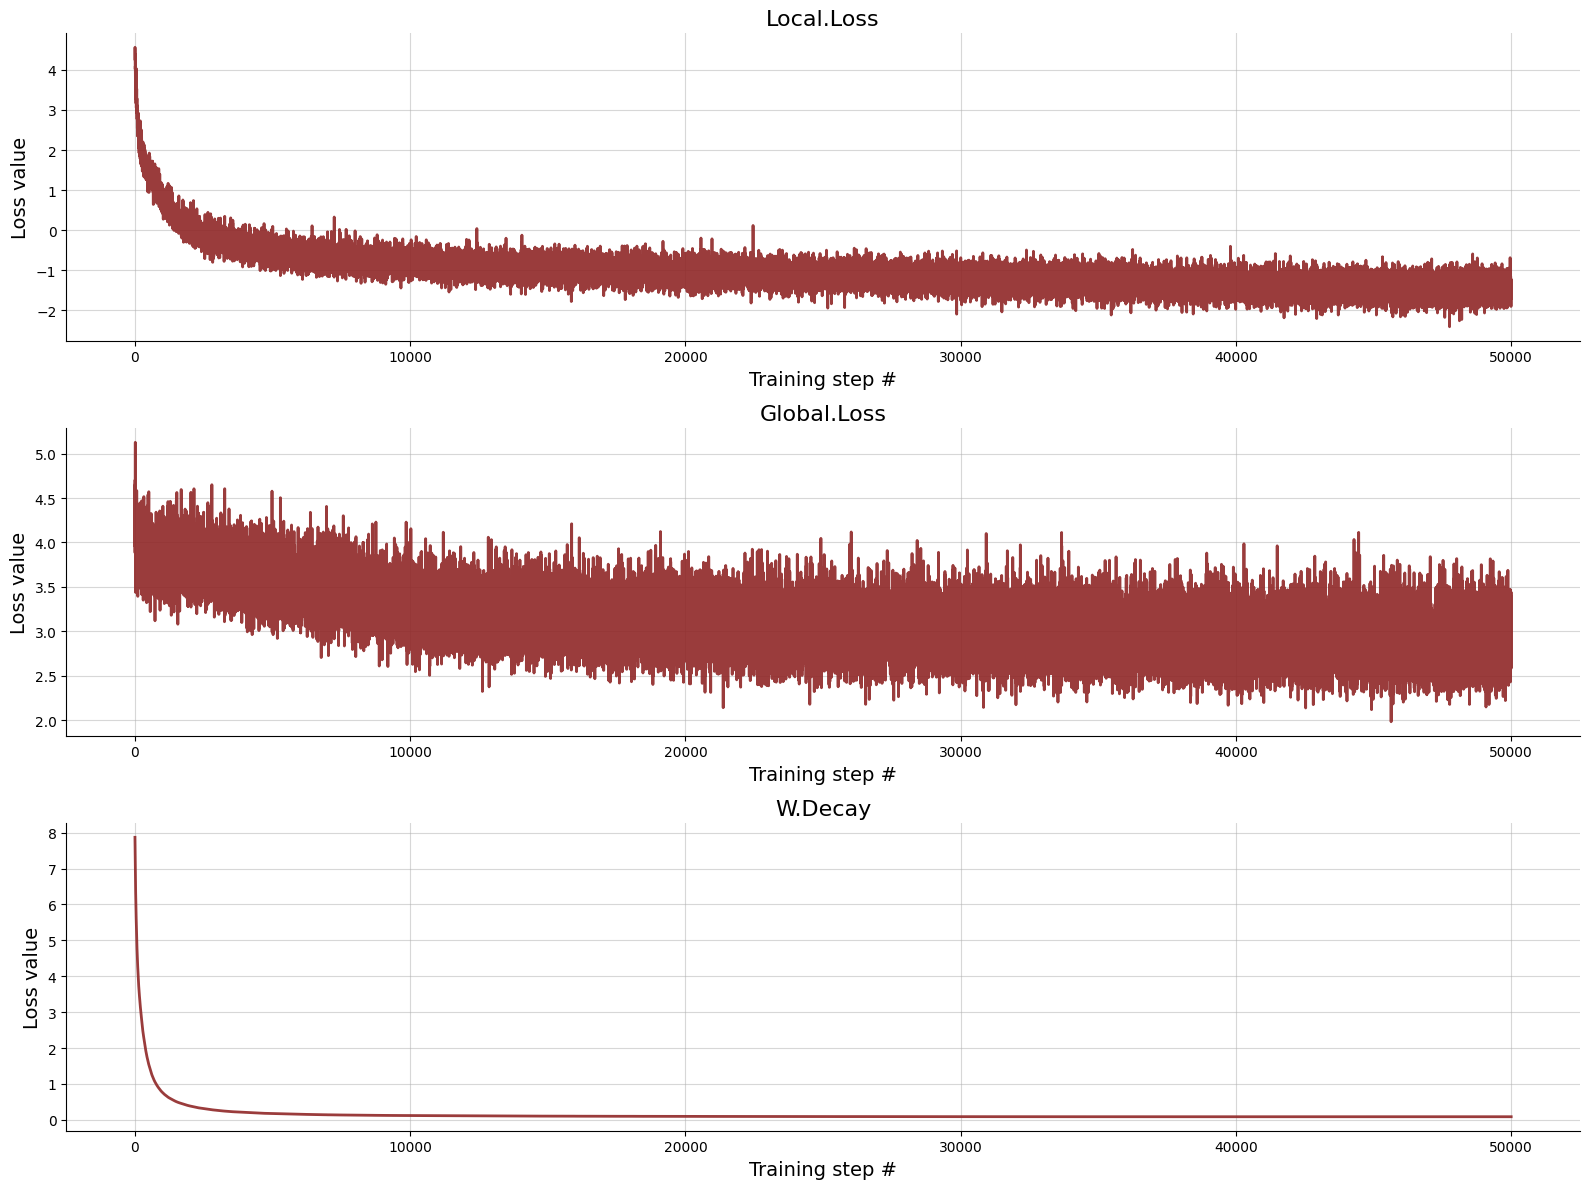

In [5]:
f = beef.diagnostics.plot_losses(history)

## Evaluation

In [5]:
data = pd.read_csv("../data/2afc_data.csv")
data["rt"][data["correct"] == 0] = -data["rt"][data["correct"] == 0]

C:\Users\selin\AppData\Local\Temp\ipykernel_18572\3704326702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["rt"][data["correct"] == 0] = -data["rt"][data["correct"] == 0]


In [6]:
N_OBS = 80
N_SUB = len(np.unique(data['id']))
N_SAMPLES = 2000
N_RESIM = 200

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']

FONT_SIZE_1 = 18
FONT_SIZE_2 = 16
FONT_SIZE_3 = 12

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [10]:
if FIT_MODEL:
    post_samples = np.zeros((N_SUB, N_OBS, N_SAMPLES, 3))
    padding = np.full((1, N_SAMPLES, 3), np.nan)
    with tf.device('/cpu:0'):
        for i in range(N_SUB):
            person_data = data[data['id'] == i+1]
            person_data = person_data['rt'].to_numpy()
            nan_idx = np.argwhere(np.isnan(person_data))
            tmp_data = person_data[np.isfinite(person_data)]
            tmp_data = {'summary_conditions': tmp_data[None, ..., None]}
            samples = neural_experiment.amortizer.sample(tmp_data, N_SAMPLES)['local_samples']
            for idx in range(nan_idx.shape[0]):
                start_idx = nan_idx[idx][0]
                samples = np.concatenate(
                    (samples[:start_idx, :, :], padding, samples[start_idx:, :, :]), axis=0
                )
            post_samples[i] = samples
    np.save("../data/posterior_samples.npy", post_samples)
else:
    post_samples = np.load("../data/posterior_samples.npy")

In [11]:
post_samples_not_z = post_samples * model.local_prior_stds + model.local_prior_means
post_means = np.nanmean(post_samples_not_z, axis=2)
post_means_mean = np.nanmean(post_means, axis=0)
post_means_std = np.nanstd(post_means, axis=0)

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_177/966091051.py:2: RuntimeWarning: Mean of empty slice
  post_means = np.nanmean(post_samples_not_z, axis=2)


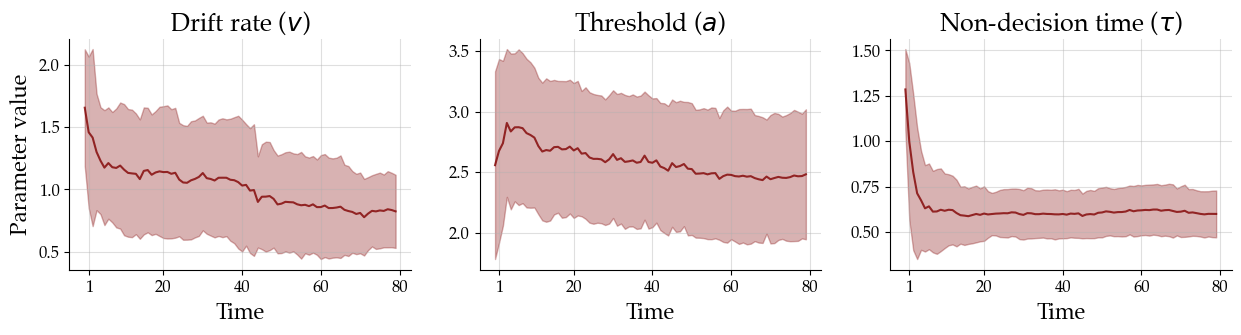

In [18]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 3))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        range(N_OBS), post_means_mean[:, i],
        color='maroon', alpha=0.8
    )
    ax.fill_between(
        range(N_OBS),
        post_means_mean[:, i] - post_means_std[:, i],
        post_means_mean[:, i] + post_means_std[:, i],
        color='maroon', alpha=0.3
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.grid(alpha=0.4)

    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time", fontsize=FONT_SIZE_2)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_xticks([1, 20, 40, 60, 80])

sns.despine()
f.tight_layout()

plt.savefig('../plots/parameter_dynamic_2afc.png', dpi=300)

## Posterior resimulation

In [34]:
if POSTERIOR_RESIMULATION:
    pred_data = np.zeros((N_RESIM, N_SUB, N_OBS, 1))
    for s in range(N_SUB):
        post_idx = np.random.choice(np.arange(N_SAMPLES), N_RESIM)
        for i in range(N_RESIM):
            idx = post_idx[i]
            pred_data[i, s] = sample_random_walk_mixture_diffusion_process(post_samples_not_z[s, :, idx])[:, None]
    np.save("../data/posterior_resimulation_hehe_hetero.npy", pred_data)
else:
    pred_data = np.load("../data/posterior_resimulation_hehe_hetero.npy")